# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

Source: 
- https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#30b6
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

Blue Score:
- https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

In [9]:
from torchtext.data.metrics import bleu_score

candidate_corpus = [['The', 'cat', 'is', 'on','the','table']]
references_corpus = [
    
        [['The', 'cat', 'is', 'on','the','table']]]

print(len(candidate_corpus))
print(len(references_corpus))
    
                    
bleu_score(candidate_corpus, references_corpus,max_n=4, weights=[0.25, 0.25, 0.25,0.25])

ImportError: /opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/torchtext/_torchtext.so: undefined symbol: _ZNK3c104Type14isSubtypeOfExtERKSt10shared_ptrIS0_EPSo

In [1]:
import time
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss as CEL
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

plt.rcParams['font.size'] = 17

In [2]:
start_token = '<BoS>'
end_token = '<EoS>'

dataset = LanguageDataset(data_path="Data/eng_ita.tsv", start_token = start_token, end_token = end_token, seq_len = 10)
train_set, val_set, test_set = dataset.get_datasets()

embedding_size = 256

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

trainloader = DataLoader(train_set, batch_size = 100)

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))

English vocabulary size for training: 8115
Italian vocabulary size for training: 13426


EPOCH 1: train loss =  4.695
EPOCH 2: train loss =  4.095
EPOCH 3: train loss =  3.728
EPOCH 4: train loss =  3.39
EPOCH 5: train loss =  3.08
EPOCH 6: train loss =  2.798
EPOCH 7: train loss =  2.548
EPOCH 8: train loss =  2.321
EPOCH 9: train loss =  2.126
EPOCH 10: train loss =  1.953
--------------------------------
Time required: 66.80890822410583


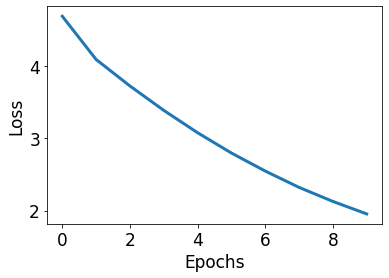

In [3]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = False)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = False)

loss_func = CEL()
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters()), 
                 decoder_optimizer = Adam(decoder.parameters()),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

start_time = time.time()
L = model.train_model(trainloader, 
                  max_epochs = 10,
                  save_every_epochs = 20,
                  ckp_name = 'test')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L, linewidth = 3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");

## Evaluation

In [5]:
testloader = DataLoader(test_set, batch_size = 100)

X, y, trans = model.evaluate_model(testloader, max_length=20)#, enc_ckp = "test_enc_20.pth", dec_ckp="test_dec_20.pth")

In [6]:
ids = 34
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> The mayor governed the city very wisely <EoS> <UNK>
Italian:  <BoS> Il sindaco dirige la città molto coscienziosamente <EoS> <UNK>
Translation:  <BoS> Il città è è la della della <EoS> <EoS>


In [7]:
ids = 12
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> When do you play tennis <EoS> <UNK> <UNK> <UNK>
Italian:  <BoS> Quando giocate a tennis <EoS> <UNK> <UNK> <UNK> <UNK>
Translation:  <BoS> Quando a a tennis <EoS> <UNK> <UNK> <UNK> <UNK>


In [8]:
ids = 67
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> The prisoner was set at liberty yesterday <EoS> <UNK>
Italian:  <BoS> Il prigioniero è stato messo in libertà ieri <EoS>
Translation:  <BoS> Il era era era stata ieri <EoS> <EoS> <UNK>
